<a href="https://colab.research.google.com/github/SmaranikaSethy/Air_Quality_Index_Project/blob/main/AQI_MODIFIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import files
uploaded = files.upload()

Saving PRSA_DATA.zip to PRSA_DATA.zip


In [20]:
import zipfile
import os

with zipfile.ZipFile("PRSA_DATA.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

os.listdir("data")

['.ipynb_checkpoints', 'PRSA_DATA']

In [22]:
import glob
import pandas as pd

files = glob.glob("data/PRSA_DATA/*.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (210384, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [24]:
# STEP 6 – FIXED VERSION FOR PRSA DATASET

# Clean column names
data.columns = [c.strip() for c in data.columns]

# ---- 1. Handle datetime ----
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')

elif 'Date' in data.columns:
    data['date'] = pd.to_datetime(data['Date'], errors='coerce')

elif set(['year','month','day','hour']).issubset(data.columns):
    # Construct datetime using PRSA-style columns
    data['date'] = pd.to_datetime(
        data[['year','month','day','hour']].astype(str).agg('-'.join, axis=1),
        format="%Y-%m-%d-%H",
        errors='coerce'
    )

else:
    raise ValueError("No valid date/time columns found!")

# Drop rows where date was not parsed
data = data.dropna(subset=['date'])

print("Datetime column created successfully!")
print(data[['date']].head())

# ---- 2. Convert pollutant columns to numeric ----
pollutants = ['PM2.5','PM10','SO2','NO2','CO','O3']

for col in pollutants:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].interpolate(limit=6).fillna(data[col].median())

# ---- 3. Meteorological data (if exists) ----
met_cols = ['Temperature','Humidity','WindSpeed','Rainfall']
for col in met_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].interpolate(limit=6).fillna(data[col].median())


Datetime column created successfully!
                 date
0 2013-03-01 00:00:00
1 2013-03-01 01:00:00
2 2013-03-01 02:00:00
3 2013-03-01 03:00:00
4 2013-03-01 04:00:00


In [25]:
print("Preprocessing completed!")
data.head()

Preprocessing completed!


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00


In [26]:
def aqi_category(pm25):
    if pm25 <= 50: return "Good"
    elif pm25 <= 100: return "Moderate"
    elif pm25 <= 200: return "Unhealthy"
    else: return "Severe"

data["AQI_label"] = data["PM2.5"].apply(aqi_category)
data["AQI_label"].value_counts()


,count
AQI_label,
Good,99956
Moderate,51851
Unhealthy,41485
Severe,17092


In [27]:
# Sort chronologically
data = data.sort_values("date")

# Time-based features
data["hour"] = data["date"].dt.hour
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["weekday"] = data["date"].dt.weekday

# Lag + Rolling averages
for col in pollutants:
    data[f"{col}_lag1"] = data[col].shift(1)
    data[f"{col}_lag2"] = data[col].shift(2)
    data[f"{col}_roll3"] = data[col].rolling(3).mean()
    data[f"{col}_roll7"] = data[col].rolling(7).mean()

# Remove rows with NaN due to lagging
data = data.dropna().reset_index(drop=True)

data.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,NO2_roll3,NO2_roll7,CO_lag1,CO_lag2,CO_roll3,CO_roll7,O3_lag1,O3_lag2,O3_roll3,O3_roll7
0,2,2013,3,1,1,7.0,7.0,3.0,10.666667,200.0,...,12.555556,23.442177,300.0,300.0,266.666667,342.857143,69.0,85.0,78.000000,81.428571
1,2,2013,3,1,1,8.0,8.0,4.0,7.000000,300.0,...,12.555556,23.442177,200.0,300.0,266.666667,342.857143,80.0,69.0,75.333333,81.428571
2,2,2013,3,1,1,6.0,15.0,5.0,79.190476,800.0,...,32.285714,22.884354,300.0,200.0,433.333333,342.857143,77.0,80.0,81.666667,81.428571
3,2,2013,3,1,1,4.0,4.0,13.0,17.000000,300.0,...,34.396825,22.884354,800.0,300.0,466.666667,342.857143,88.0,77.0,79.000000,79.000000
4,2,2013,3,1,1,4.0,4.0,3.0,16.000000,300.0,...,37.396825,22.408163,300.0,800.0,466.666667,357.142857,72.0,88.0,82.666667,79.857143


In [29]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [35]:
# STEP 9 — Time-based split + remove leakage

data = data.sort_values("date")

X = data.drop(columns=["AQI_label", "date"])
X = X.select_dtypes(include=[np.number])

y = data["AQI_label"]

# Time-based split
split_idx = int(len(data) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# REMOVE PM2.5 (label is based on PM2.5 ⇒ leakage)
if "PM2.5" in X_train.columns:
    X_train = X_train.drop(columns=["PM2.5"])
    X_test = X_test.drop(columns=["PM2.5"])

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (167721, 40) Test: (41931, 40)


In [36]:
# REMOVE PM2.5 because it directly determines AQI category
if "PM2.5" in X_train.columns:
    X_train = X_train.drop(columns=["PM2.5"])
    X_test = X_test.drop(columns=["PM2.5"])


In [37]:
# STEP 10 — Improved Random Forest to reduce overfitting

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, rf_pred))
print("RF F1:", f1_score(y_test, rf_pred, average="macro"))


RF Accuracy: 0.9183420381102287
RF F1: 0.9072189149647178


In [38]:
rf_train_pred = rf.predict(X_train)

print("Training Accuracy:", accuracy_score(y_train, rf_train_pred))
print("Training F1:", f1_score(y_train, rf_train_pred, average="macro"))


Training Accuracy: 0.9116926324073908
Training F1: 0.8993506331271743


In [40]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and transform y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=10,
    reg_lambda=15,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train_encoded)
xgb_pred_encoded = xgb.predict(X_test)
xgb_pred = le.inverse_transform(xgb_pred_encoded)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost F1:", f1_score(y_test, xgb_pred, average="macro"))

XGBoost Accuracy: 0.926784479263552
XGBoost F1: 0.9193512358712717


In [41]:
print("=== RANDOM FOREST REPORT ===")
print(classification_report(y_test, rf_pred))

print("=== XGBOOST REPORT ===")
print(classification_report(y_test, xgb_pred))

=== RANDOM FOREST REPORT ===
              precision    recall  f1-score   support

        Good       0.97      0.95      0.96     20528
    Moderate       0.83      0.90      0.86     10435
      Severe       0.95      0.91      0.93      3378
   Unhealthy       0.89      0.85      0.87      7590

    accuracy                           0.92     41931
   macro avg       0.91      0.90      0.91     41931
weighted avg       0.92      0.92      0.92     41931

=== XGBOOST REPORT ===
              precision    recall  f1-score   support

        Good       0.97      0.96      0.96     20528
    Moderate       0.86      0.89      0.87     10435
      Severe       0.94      0.95      0.95      3378
   Unhealthy       0.91      0.88      0.89      7590

    accuracy                           0.93     41931
   macro avg       0.92      0.92      0.92     41931
weighted avg       0.93      0.93      0.93     41931



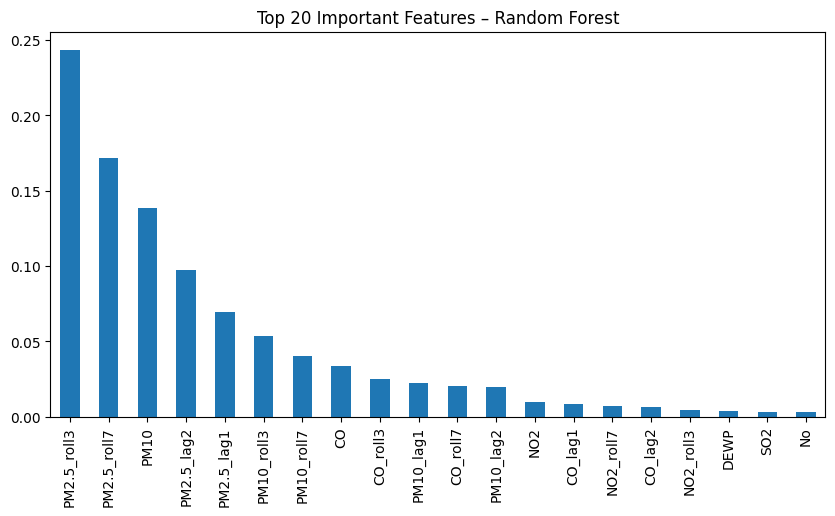

In [43]:
import matplotlib.pyplot as plt

fi = pd.Series(rf.feature_importances_, index=X_train.columns)
fi.nlargest(20).plot(kind="bar", figsize=(10,5))
plt.title("Top 20 Important Features – Random Forest")
plt.show()